
# [CoE202] **[Homework3]** CNN Classification for CIFAR10 (Pytorch)
## **Training Script**

In this section, you are going to **train** CNN classification for CIFAR10 in the Pytorch framework.


# 0. Import Library


In [1]:
# import numpy as np
# import matplotlib.pyplot as plt # this is for importing matplotlib.pyplot (library for graph plot)
# import math
# import torch
# import torch.nn as nn
# import torchvision
# import torch.nn.functional as F
# import torchvision.transforms as transforms

# from google.colab import files
# from google.colab import drive
# drive.mount('/content/gdrive')

import torch
import math
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. Set hyper-parameters


If you change this part, write why changing the parameter will improve the performance at the end of the .ipynb file.

In [2]:
# Set several hyperparameters and settings
batch_size = 50 # default = 128
n_epoch = 60 # default = 200
learning_rate = 0.0003 # default = 0.1
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # to tensor before normalize
])
validation_transform = transforms.Compose([
#     transforms.Grayscale(), 
    transforms.ToTensor(), # to tensor @ Normalize must be at the end
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # to tensor before normalize
])

shuffle = False
target_transform = None

In [3]:
seed = 1
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 2. Load CIFAR10 data from torchvision dataset

In [4]:
# load CIFAR10 data
train_dataset = datasets.CIFAR10("../cifar10_data/",
                                               download=True,
                                               train=True,
                                               transform=train_transform)

validation_dataset = datasets.CIFAR10("../cifar10_data/",
                                              download=True,
                                              train=False,
                                              transform=validation_transform, target_transform=target_transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, drop_last = True)
validation_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle=False, drop_last = True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
[one_batch_data, one_batch_label] = next(iter(train_loader))
print(one_batch_data.size(), one_batch_label.size())

torch.Size([50, 3, 32, 32]) torch.Size([50])


# 3. Define functions for plotting result

In [6]:
def vismod_img(img):
    """Change the order of dimesion before visualize.

    Args:
        img (torch.Tensor) : Image to plot. Dimension of [Channel, Height, Width]
    
    Returns:
        npimg (numpy.ndarray) : Numpy array of input img. Dimension of [Height, Width, Channel]
    """
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

def show_data(data, label, classes):
    """Plot grids composed of multiple images and labels in the batch.

    Args:
        data (torch.Tensor) : Images to plot. Dimension of [Batch size, Channel, Height, Width]
        label (torch.Tensor) : Ground Truth labels correspond to Images. Dimension of [Batch size]
        classes (tuple) : Tuple with class names.
    
    Returns:
        None, matplotlib.pyplot window will appear.
    """
    num_row = 2
    num_col = 4
    fig, axes = plt.subplots(num_row, num_col)
    for i in range(8):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(vismod_img(data[i].cpu()))
        ax.set_title(f'label : {classes[label[i].cpu().item()]}')
    plt.tight_layout()
    plt.show()

def show_inference_result(data, label, output, classes):
    """Plot grids composed of multiple images and labels in the batch, with predicted ouptut.

    Args:
        data (torch.Tensor) : Images to plot. Dimension of [Batch size, Channel, Height, Width]
        label (torch.Tensor) : Ground Truth labels correspond to Images. Dimension of [Batch size]
        label (torch.Tensor) : Predicted labels correspond to Images. Dimension of [Batch size]

    Returns:
        None, matplotlib.pyplot window will appear.
    """
    num_row = 2
    num_col = 4
    fig, axes = plt.subplots(num_row, num_col)
    for i in range(8):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(vismod_img(data[i].cpu()))
        ax.set_title(f'GT : {classes[label[i].cpu().item()]} \n output : {classes[output[i].cpu().item()]}')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(Training Data) ground truth example


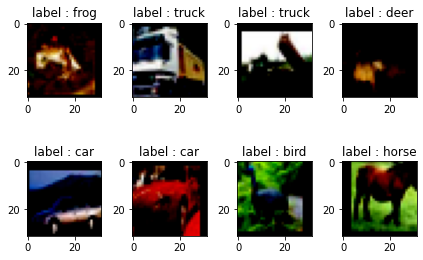

In [7]:
# show ground truth classification (one batch)
print('(Training Data) ground truth example')
show_data(one_batch_data, one_batch_label, classes) # 10

# 4. Define CNN model




Here we have provided a classifier model in DNN.
Your task is to change this model into CNN, and achieve 93% accuracy in test data set.

If your submitted model is not CNN, no points will be given.

In [8]:
class CNN(nn.Module): 
    def __init__(self): 
        super(CNN, self).__init__()
        # anh ban dau = 32 * 32 * 3
        # self.conv1  = nn.Conv2d(input_channel, output_channel, ...)
        self.batchNorm1 = nn.BatchNorm2d(90)
        self.batchNorm2 = nn.BatchNorm2d(270)
        self.batchNorm3 = nn.BatchNorm2d(270 * 4)
        self.conv1 = nn.Conv2d(3, 90, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(90, 270, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(270, 270 * 4, kernel_size=3, stride=1, padding=0)
#         self.conv4 = nn.Conv2d(270, 270 * 3, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(270*4*3*3, 512)
        self.fc2 = nn.Linear(512, 10)
#         self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x): 
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.maxPool(x)
        x = self.relu(self.conv2(x))
        x = self.batchNorm2(x)
        x = self.maxPool(x)
        x = self.conv3(x)
        x = self.batchNorm3(x)
        x = self.relu(x)
        x = self.maxPool(x)
        x = x.view(-1, 270*4*3*3)
        if self.training == True: 
            x = self.dropout(x)
        x = self.relu(self.fc1(x))
        if self.training == True: 
            x = self.dropout(x)
        x = self.relu(self.fc2(x))
        
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current classification


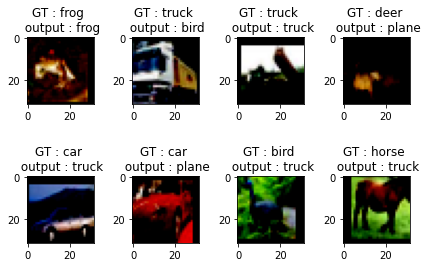

In [9]:
def weights_init(m):
    """Initialize weights.

    Args:
        m (subclass of torch.nn.modules) : module to initialize weight

    Returns:
        None, replace weights of m with initializing method
    """
    if isinstance(m, nn.Linear):
        bound = 1 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, bound)
        nn.init.uniform_(m.bias, -bound, bound)

def thresholding(prediction):
    """Find label which shows highest prediction value.
    
    Args:
        prediction (torch.tensor) : prediction tensor. Dimension of [Batch size, 10]
    
    Returns:
        pred_label (torch.tensor) : Index which shows maximum prediction value. Dimension of [Batch size]
    """
    _, pred_label = torch.max(prediction, 1)
    return pred_label

my_classifier = CNN()  # assign classifier
my_classifier = my_classifier.to(device)
my_classifier.apply(weights_init)  # applying weights_init function to linear layers

# show the performance of untrained classifier
print('current classification')
prediction = my_classifier(one_batch_data.to(device))  # passing forward function of classifier, return prediction
show_inference_result(one_batch_data, one_batch_label, thresholding(prediction), classes)

In [10]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
print(get_n_params(my_classifier))

7832132


# 5. Train CNN classifier and monitor loss and accuracy for train & validation set

You can change the optimizer to improve performance.
If you change the optimizer, please write why changing it improves performance at the end of the .ipynb file.

In [11]:
optimizer = torch.optim.Adam(my_classifier.parameters(), lr=learning_rate, weight_decay=0.0008)

In [12]:
# train cnn classifier
train_loss_iter = np.zeros(n_epoch, dtype=float)  # Temporary numpy array to save loss for each epoch
validation_loss_iter = np.zeros(n_epoch, dtype=float)
train_accuracy_iter = np.zeros(n_epoch, dtype=float)  # Temporary numpy array to save accuracy for each epoch
validation_accuracy_iter = np.zeros(n_epoch, dtype=float)

loss_function = torch.nn.CrossEntropyLoss()
# Assign cross-entropy loss

for epoch in range(n_epoch):  # We will iteratively find optimum
    # Training
    my_classifier.train()
    total_loss, total_cnt, correct_cnt = 0.0, 0.0, 0.0
    best_acc = 0.0
    
    for batch_idx, (image, label) in enumerate(train_loader): # current len(train_loader) = 390
        image, label = image.to(device), label.to(device)
        pred = my_classifier(image)  # Find output of classifier
        
        optimizer.zero_grad()  # Pytorch does not overwrite gradients, it 'accumulates' them so that we need to set gradient as 0 to update parameter correctly
        loss = loss_function(pred, label)  # Calculate cross-entropy loss between prediction and label
        loss.backward()  # Pytorch automatically back-propagate and calculate gradients
        optimizer.step()  # From calculated gradients, change parameters of classifier with SGD algorithm

        total_loss += loss.item()
        total_cnt += len(label)
        correct_cnt += (pred.argmax(1) == label).type(torch.float).sum().item()

    
    accuracy = correct_cnt * 1.0 / total_cnt
    train_loss_iter[epoch] = total_loss / total_cnt
    train_accuracy_iter[epoch] = accuracy
        
    
    print(f"[{str(epoch).zfill(len(str(n_epoch)))}/{n_epoch}] Train Loss  : {train_loss_iter[epoch]:.6f}, Acc = {100*train_accuracy_iter[epoch]:.2f}%")
    
    # validation
    my_classifier.eval()
    total_loss, total_cnt, correct_cnt = 0.0, 0.0, 0.0
    for batch_idx, (image, label) in enumerate(validation_loader):
        with torch.no_grad():
            image, label = image.to(device), label.to(device)
            
            pred = my_classifier(image)
            loss = loss_function(pred, label)

            total_loss += loss.item()
            total_cnt += len(label)
            correct_cnt += (pred.argmax(1) == label).type(torch.float).sum().item()
    
    accuracy = correct_cnt * 1.0 / total_cnt
    validation_loss_iter[epoch]  = total_loss / total_cnt
    validation_accuracy_iter[epoch] = accuracy

    
    print(f"[{str(epoch).zfill(len(str(n_epoch)))}/{n_epoch}] Validation Loss : {validation_loss_iter[epoch]:.6f}, Acc = {100*validation_accuracy_iter[epoch]:.2f}%")

[00/60] Train Loss  : 0.046057, Acc = 10.05%
[00/60] Validation Loss : 0.046052, Acc = 10.00%
[01/60] Train Loss  : 0.046052, Acc = 9.99%
[01/60] Validation Loss : 0.046052, Acc = 10.00%
[02/60] Train Loss  : 0.044372, Acc = 12.07%
[02/60] Validation Loss : 0.042285, Acc = 15.28%
[03/60] Train Loss  : 0.037084, Acc = 30.31%
[03/60] Validation Loss : 0.031423, Acc = 41.37%
[04/60] Train Loss  : 0.031421, Acc = 45.88%
[04/60] Validation Loss : 0.026409, Acc = 55.97%
[05/60] Train Loss  : 0.028554, Acc = 52.93%
[05/60] Validation Loss : 0.025056, Acc = 57.95%
[06/60] Train Loss  : 0.027243, Acc = 54.65%
[06/60] Validation Loss : 0.024482, Acc = 58.98%
[07/60] Train Loss  : 0.024961, Acc = 59.33%
[07/60] Validation Loss : 0.019567, Acc = 68.88%
[08/60] Train Loss  : 0.020769, Acc = 66.38%
[08/60] Validation Loss : 0.017766, Acc = 71.04%
[09/60] Train Loss  : 0.017845, Acc = 70.30%
[09/60] Validation Loss : 0.013645, Acc = 76.85%
[10/60] Train Loss  : 0.015812, Acc = 73.21%
[10/60] Validati

#6-1. Plot loss for train, validation set

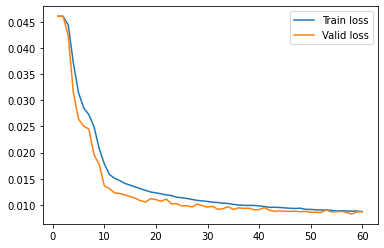

In [13]:
# show loss during training
l1, = plt.plot(range(1,n_epoch+1), train_loss_iter)
l2, = plt.plot(range(1,n_epoch+1), validation_loss_iter)
plt.legend(handles=(l1, l2), labels=('Train loss', 'Valid loss'))

#6-2. Plot accuracy for train, validation set

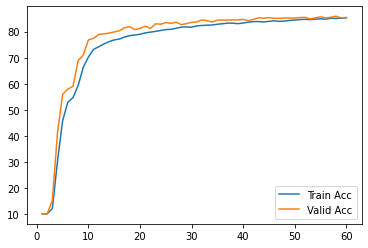

In [14]:
# show accuracy during training
l1, = plt.plot(range(1,n_epoch+1), 100*train_accuracy_iter)
l2, = plt.plot(range(1,n_epoch+1), 100*validation_accuracy_iter)
plt.legend(handles=(l1, l2), labels=('Train Acc', 'Valid Acc'))

#7. Visualize classification result of validation set after training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After training


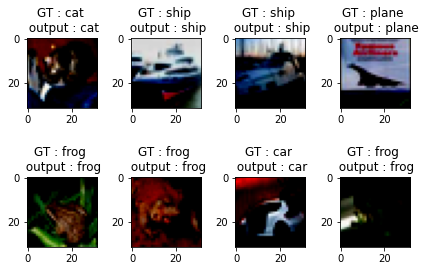

In [15]:
# For validation data
print('After training')
[one_batch_data, one_batch_label] = next(iter(validation_loader))
prediction = my_classifier(one_batch_data.to(device))
show_inference_result(one_batch_data, one_batch_label, thresholding(prediction), classes)

In [17]:

model_save_name = 'checkpoint.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 

# torch.save(checkpoint, path)
torch.save(my_classifier.state_dict(), path)

# 8. Report
Write your explanations about the code that you have implemented.

**Q1.** Write down why changing the parameter in **2. Set hyper-parameters** will improve the performance.

- I changed batch_size from 128 -> 50 for faster convergence of the model.
- I changed learning rate from 0.1 -> 0.0003 for Adam Optimizer because after some trials with higher learning rate, I observed that the model could not learn. (loss of both training and validation kept constant)
- I change shuffle from True -> False with expectation that the data would be consistent in the flow of trainning. However, I did not observed any difference in performance of my model between shuffling the training input or not.
- I changed number of epochs from 200 -> 60 because after 60 epochs the validation loss decreases as I observed in some last trials. 

**Q2.** If you changed the **optimizer**, please write why changing it improves performance.

The Adam optimizer is deployed with learning rate 0.0003, this optimizer utilize adaptive learning rate for each parameters which is usually faster and more effectively for convergence than SGD in most case, maybe also overfitting faster and this will help to notice the error ealier. (higher learning rate for Adam prevent the model from learning as I observed from some trials)

**Q3.** Please give explanations about your CNN model, and explain what helped you improve the performance. (Please discuss your trials of implementing the CNN model)

Phase 1 

    - Batch_size is set to 50 for faster convergence of model
    - 3 convolution layer with kernel size = 3, maxpooling = 2x2 and stride = 2
    - 3 Fully connected layer
    - Validation accuracy increase and stop at 77%, training accuracy reach 100% at the end
    - Overfitting occured
    => We need to decreases the capacity of the model to prevent overfitting
    
Phase 2: 

    - 3 convolution layer with kernel size = 3, maxpooling = 2x2 and stride = 2: Image 3*32*32 -> 360*3*3
    - 2 Fully connected layer: 90 * 4 * 3 -> 1024 -> 10
    - Training accuracy reached over 90%, validation loss stopped at 71%
    - Overfitting occured again, the decrease of capacity did not work.
    => In next phase, we will try to increase the capacity and use dropout to prevent overfitting
    
Phase 3: 

    - 3 convolution layer with kernel size = 3, maxpooling = 2x2 and stride = 2: Image 3*32*32 -> 1920*3*3
    - 2 Fully connected layer: 1920 * 4 * 3 -> 10 (input - output)
    - Dropout with p=0.3 before each fully connected layer
    - Trainning accuracy eached nearly 100%, validation stopped at 79%
    - Result is improved but overfitting still occured 
    => In next phase, we will try increase dropout rate to 0.5, allow dropout between 2 convolution layer, and transform images to grayscale as well as normalizing them to have similar value range and see if they could reduce the overfitting effects.
        Also, the Adam optimizer will be deployed with learning rate 0.0003, this optimizer utilize adaptive learning rate for each parameters which is usually faster for convergence than SGD in most case, maybe also overfitting faster (higher learning rate for Adam prevent the model from learning as I observed from some trials).

Phase 4: 

    - 4 convolution layers: [Conv2d -> relu -> Conv2d -> relu -> maxpooling] * 2 
    - 3 fully connected layers: 270 * 2 * 6 * 6 -> 1024 -> 256 -> 10
    - Dropout with p=0.5 before each convolution layers and before each fully connected layers
    - Image transformation = Grayscale + Normalize(0.5, 0.5, 0.5)
    - The model converge to >70% faster (under 10 epochs from scratch).
    - I stopped the model at trainning accuracy = 94%, validation accuracy had stopped at 78% for a while and the validation loss started decreasing.
    - The overfitting kept occurring. The model converge faster.
    - I realized that this model with grayscale + Normalization transformation does not work well with image without same transformation. The image need to be transformed similarly before push into model for prediction. This is might due to the difference in range of value, as the trainning images have been normalized.
    => Next phase, we will try to use batch normalization, which normalize the range of value in each batch and may help increase the generalization of the model.
    
Phase 5: 

    - 4 convolution layers: [Conv2d -> batch_normalize -> relu -> maxpooling] * 4
    - 2 fully connected layers: 810*1*1 -> 256 -> 10
    - Dropout with p=0.5 only before each fully connected layers, I have read that dropout in convolution layers usually bring wierd result, and it has different effect as dropout in fully connected layers
    - Image transformation = Normalize(0.5, 0.5, 0.5)
    - The validation loss started decreases from epochs 20, trainning accuracy > 90% and validation accuracy kept at 77%, No noticable improvement.
    - Overfitting has not been solved.
    => We will try l2-regularization for the next phase with weight-decay=0.005 to see if it could effectively penalize the over-complexity of model and reduce the overfitting effects.

Phase 6: 

    - 3 convolution layers: [Conv2d -> batch_normalize -> relu -> maxpooling] * 3
    - 2 fully connected layers: 270*4*3*3 -> 512 -> 10
    - Dropout with p=0.5 only before each fully connected layers
    - Weight-decay factor = 0.005 for Adam Optimizer.
    - Image transformation = Normalize(0.5, 0.5, 0.5)
    - I stopped at epochs 103, as validation loss had increased for a while. Trainning accuacy = 88%, validation accuracy = 82%. 
    - Result is improved, and overfitting occur later than last phase.
    => We will try Horizontal flip and RandomCrop for training transformation to create more random image, help to generalize the training data more and check if it could reduce the overfitting effects. Also, the batch-normalization will be placed after each conv2d layer and the weight-decay will be decrease to 0.0008 (As I did try some trials beforehand with same configurations and higher weight-decay but the model could not learn after reaching traing accuracy = ~77%)

Phase 7: (Final)

    - 3 convolution layers: [Conv2d -> batch_normalize -> relu -> maxpooling] * 3
    - 2 fully connected layers: 270*4*3*3 -> 512 -> 10
    - Weight-decay factor = 0.0008 for Adam Optimizer
    - Dropout with p=0.5 only before each fully connected layers
    - Image transformation = Normalize(0.5, 0.5, 0.5), RandomHorizontalFlip, RandomCrop(32,padding=4).
    - The validation loss started increasing from ~epoch 60, the training accuracy ~85%, validation accuracy ~85%
    - The result is improved. The overfitting happened later than last phase.
    The result is finalized here!


**Q4.** If you change **1. Import Library**, write the usage of the library.

I just import some modules of pytorch in a more direct way for more convenience. There is no new module in compare with modules used in sample code.